# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set seaborn style
sns.set_style("ticks")
sns.color_palette("husl", 8)
sns.set_context("paper", font_scale=1.0)

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

2023-10-30 21:22:58.616935: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 21:22:58.616960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 21:22:58.616997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 21:22:58.624299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/swapnil/uni/ECE1512H_2023F_ProjectRepo_Swapn

# Data loading

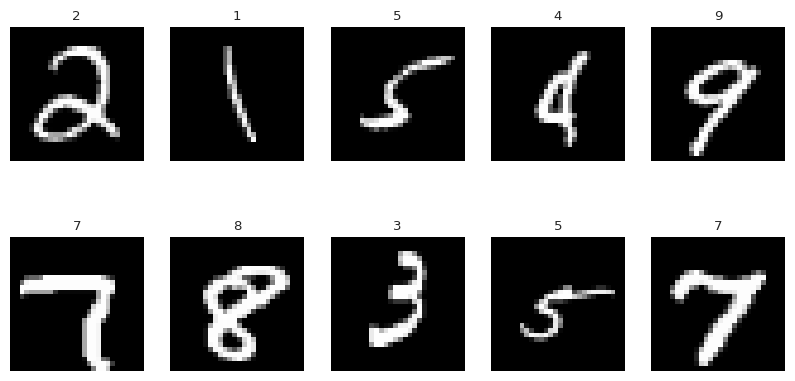

In [30]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# visualize 10 classes of MNIST
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for img, label in mnist_train.take(1):
  for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(img[i, :, :, 0], cmap='gray')
    ax.set_title(label[i].numpy().argmax())
    ax.set_axis_off()
plt.savefig('./report/figures/mnist.png', dpi=300, bbox_inches='tight')

# Model creation

In [3]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=1, padding="same"))
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding="same"))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(NUM_CLASSES))

#cnn_model.summary()

# Build fully connected student.
fc_model = tf.keras.Sequential()

# your code start from here for step 2
fc_model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(NUM_CLASSES))

default_weights = fc_model.get_weights()
#fc_model.summary()

# Teacher loss function

In [4]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.categorical_crossentropy(labels, subclass_logits, from_logits=True)


  return cross_entropy_loss_value

# Student loss function

In [5]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.keras.activations.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.categorical_crossentropy(labels, student_subclass_logits, from_logits=True)

  return ALPHA * cross_entropy_loss_value + (1 - ALPHA) * distillation_loss_value

# Train and evaluation

In [6]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  
  Returns:
    Class accuracy on test dataset.
  """
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  accuracies = []
  print("Class_Accuracy:\t", end='')
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    #print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    class_accuracy = num_correct / num_total * 100
    accuracies.append(class_accuracy.numpy())
    print("{:.2f}%\t".format(class_accuracy, width=7), end='')
  print()
  accuracies = np.round(accuracies, 2)
  return accuracies

# Training models

Class_Accuracy:	

2023-10-30 21:23:03.047971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-30 21:23:04.265096: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5644d6aa7930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-30 21:23:04.265115: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-10-30 21:23:04.268826: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-30 21:23:04.347506: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98.01%	98.73%	98.87%	98.98%	99.00%	99.00%	99.15%	99.14%	99.15%	99.11%	99.19%	99.20%	


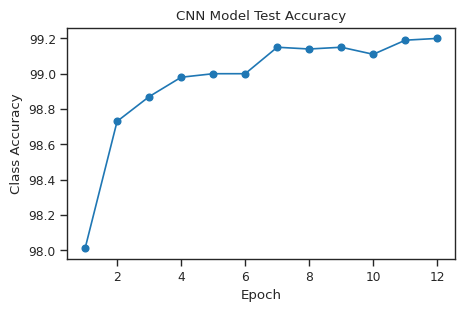

In [7]:
# your code start from here for step 5 

cnn_model_acc = train_and_evaluate(cnn_model, compute_teacher_loss)
# cnn_model.save_weights('./models/cnn_model.h5')

fig = plt.figure(figsize=(5, 3))
plt.plot(range(1, NUM_EPOCHS + 1), cnn_model_acc, "-o", label='CNN Model')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy')
plt.title('CNN Model Test Accuracy') 
plt.savefig('./report/figures/cnn_model_acc.png', dpi=300, bbox_inches='tight')

Class_Accuracy:	96.55%	97.79%	98.21%	98.27%	98.56%	98.60%	98.51%	98.60%	98.66%	98.66%	98.57%	98.72%	


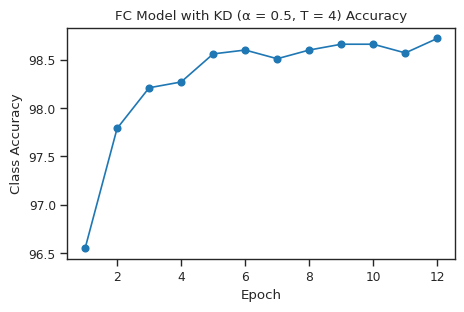

In [8]:
ALPHA = 0.5                     #   task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4    #   temperature hyperparameter

accuracies = train_and_evaluate(fc_model, compute_student_loss)
# fc_model.save_weights('./models/fc_model.h5')
 
fig = plt.figure(figsize=(5, 3))
plt.plot(range(1, NUM_EPOCHS + 1), accuracies, "-o", label='Student')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy')
plt.title('FC Model with KD (α = 0.5, T = 4) Accuracy')
plt.savefig('./report/figures/fc_model_acc.png', dpi=300, bbox_inches='tight')

# Test accuracy vs. tempreture curve

DISTILLATION_TEMPERATURE: 1
Class_Accuracy:	96.74%	97.48%	97.52%	97.98%	97.62%	98.02%	98.13%	98.19%	98.34%	98.35%	98.24%	98.50%	
DISTILLATION_TEMPERATURE: 2
Class_Accuracy:	96.65%	97.72%	98.10%	98.17%	98.36%	98.37%	98.49%	98.33%	98.46%	98.60%	98.27%	98.39%	
DISTILLATION_TEMPERATURE: 4
Class_Accuracy:	96.41%	97.81%	98.11%	98.26%	98.37%	98.49%	98.56%	98.54%	98.55%	98.61%	98.60%	98.62%	
DISTILLATION_TEMPERATURE: 16
Class_Accuracy:	96.46%	97.78%	98.11%	98.21%	98.45%	98.57%	98.59%	98.59%	98.66%	98.61%	98.77%	98.67%	
DISTILLATION_TEMPERATURE: 32
Class_Accuracy:	96.52%	97.69%	98.02%	98.27%	98.36%	98.47%	98.50%	98.49%	98.65%	98.70%	98.73%	98.71%	
DISTILLATION_TEMPERATURE: 64
Class_Accuracy:	96.40%	97.77%	98.04%	98.32%	98.33%	98.57%	98.55%	98.66%	98.65%	98.69%	98.75%	98.84%	


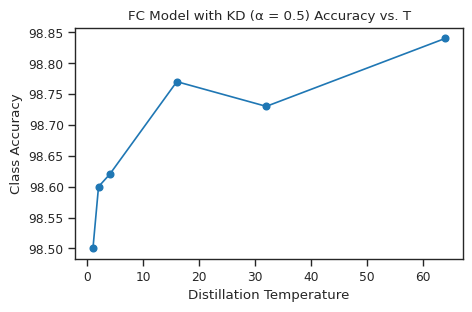

In [9]:
# your code start from here for step 6

ALPHA = 0.5
DISTILLATION_TEMPERATURE_LIST = [1, 2, 4, 16, 32, 64]
accuracies = []
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_LIST:
  print("DISTILLATION_TEMPERATURE: " + str(DISTILLATION_TEMPERATURE))
  # clear model
  tf.keras.backend.clear_session()
  fc_model.set_weights(default_weights)
  a_ = train_and_evaluate(fc_model, compute_student_loss)
  accuracies.append(np.max(a_))
  # fc_model.save_weights('./models/fc_model_' + str(DISTILLATION_TEMPERATURE) + '.h5')

fig = plt.figure(figsize=(5, 3))
plt.plot(DISTILLATION_TEMPERATURE_LIST, accuracies, "-o", label='Student')
plt.xlabel('Distillation Temperature')
plt.ylabel('Class Accuracy')
plt.title('FC Model with KD (α = 0.5) Accuracy vs. T')
plt.savefig('./report/figures/fc_model_acc_vs_t.png', dpi=300, bbox_inches='tight')

ALPHA: 0.1, DISTILLATION_TEMPERATURE: 1
Class_Accuracy:	96.58%	97.27%	97.70%	97.96%	98.23%	98.21%	98.37%	98.47%	98.34%	98.35%	97.98%	98.19%	
ALPHA: 0.1, DISTILLATION_TEMPERATURE: 2
Class_Accuracy:	96.53%	97.42%	98.07%	98.34%	98.51%	98.48%	98.48%	98.45%	98.38%	98.51%	98.50%	98.52%	
ALPHA: 0.1, DISTILLATION_TEMPERATURE: 4
Class_Accuracy:	96.67%	97.76%	98.25%	98.35%	98.47%	98.52%	98.68%	98.56%	98.59%	98.60%	98.67%	98.64%	
ALPHA: 0.1, DISTILLATION_TEMPERATURE: 16
Class_Accuracy:	96.48%	97.66%	98.01%	98.18%	98.26%	98.29%	98.46%	98.52%	98.47%	98.57%	98.62%	98.65%	
ALPHA: 0.1, DISTILLATION_TEMPERATURE: 32
Class_Accuracy:	96.34%	97.60%	98.05%	98.24%	98.33%	98.37%	98.47%	98.52%	98.50%	98.56%	98.61%	98.60%	
ALPHA: 0.1, DISTILLATION_TEMPERATURE: 64
Class_Accuracy:	96.62%	97.75%	98.00%	98.24%	98.42%	98.41%	98.52%	98.52%	98.63%	98.71%	98.77%	98.74%	
ALPHA: 0.3, DISTILLATION_TEMPERATURE: 1
Class_Accuracy:	97.26%	97.58%	98.08%	97.82%	98.22%	98.31%	98.13%	98.40%	98.45%	98.26%	98.49%	98.04%	
ALPHA: 0.3

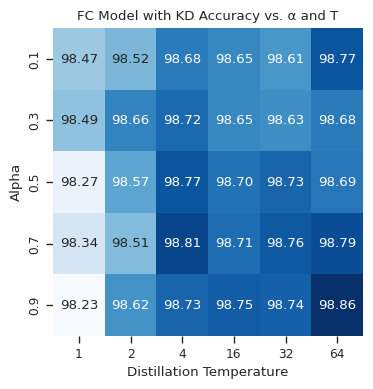

In [10]:
ALPHA_LIST = [0.1, 0.3, 0.5, 0.7, 0.9]
DISTILLATION_TEMPERATURE_LIST = [1, 2, 4, 16, 32, 64]
accuracies = np.zeros((len(ALPHA_LIST), len(DISTILLATION_TEMPERATURE_LIST)))

for i, ALPHA in enumerate(ALPHA_LIST):
    for j, DISTILLATION_TEMPERATURE in enumerate(DISTILLATION_TEMPERATURE_LIST):
        print("ALPHA: " + str(ALPHA) + ", DISTILLATION_TEMPERATURE: " + str(DISTILLATION_TEMPERATURE))

        tf.keras.backend.clear_session()
        fc_model.set_weights(default_weights)

        a_ = train_and_evaluate(fc_model, compute_student_loss)
        accuracies[i][j] = np.max(a_)
        # fc_model.save_weights('./models/fc_model_' + str(ALPHA) + '_' + str(DISTILLATION_TEMPERATURE) + '.h5')
        
# heatmap for ALPHA and DISTILLATION_TEMPERATURE
fig = plt.figure(figsize=(4, 4))
ax = sns.heatmap(accuracies, annot=True, fmt=".2f", cmap="Blues", cbar=False)
ax.set_xticklabels(DISTILLATION_TEMPERATURE_LIST)
ax.set_yticklabels(ALPHA_LIST)
plt.xlabel('Distillation Temperature')
plt.ylabel('Alpha')
plt.title('FC Model with KD Accuracy vs. α and T')
plt.savefig('./report/figures/fc_model_heatmap.png', dpi=300, bbox_inches='tight')


# Train student from scratch

In [11]:
# Build fully connected student.
fc_model_noKD = tf.keras.Sequential()

# your code start from here for step 7
fc_model_noKD.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
fc_model_noKD.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_noKD.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_noKD.add(tf.keras.layers.Dense(NUM_CLASSES))

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_noKD(images, training=True)
  cross_entropy_loss = tf.keras.losses.categorical_crossentropy(labels, student_subclass_logits, from_logits=True)
  
  return cross_entropy_loss


# train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

Class_Accuracy:	96.68%	97.35%	98.00%	98.37%	98.47%	98.48%	98.47%	98.54%	98.62%	98.63%	98.65%	98.72%	
Class_Accuracy:	96.86%	97.66%	97.88%	97.94%	97.47%	97.56%	97.97%	98.14%	97.94%	98.06%	98.00%	97.98%	


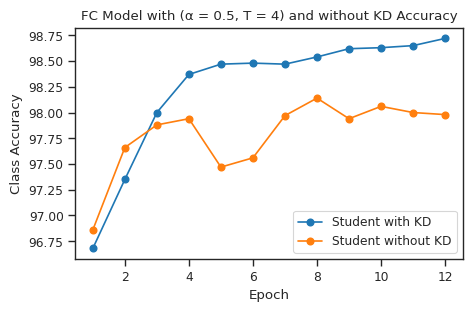

In [12]:
# your code start from here for step 8
ALPHA= 0.5
DISTILLATION_TEMPERATURE = 4

tf.keras.backend.clear_session()
fc_model.set_weights(default_weights)

withKD_acc = train_and_evaluate(fc_model, compute_student_loss)
withoutKD_acc = train_and_evaluate(fc_model_noKD, compute_plain_cross_entropy_loss)

fig = plt.figure(figsize=(5, 3))
plt.plot(range(1, NUM_EPOCHS + 1), withKD_acc, "-o", label='Student with KD')
plt.plot(range(1, NUM_EPOCHS + 1), withoutKD_acc, "-o", label='Student without KD')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy')
plt.title('FC Model with (α = 0.5, T = 4) and without KD Accuracy')
plt.legend()
plt.savefig('./report/figures/fc_with_withoutKD.png', dpi=300, bbox_inches='tight')

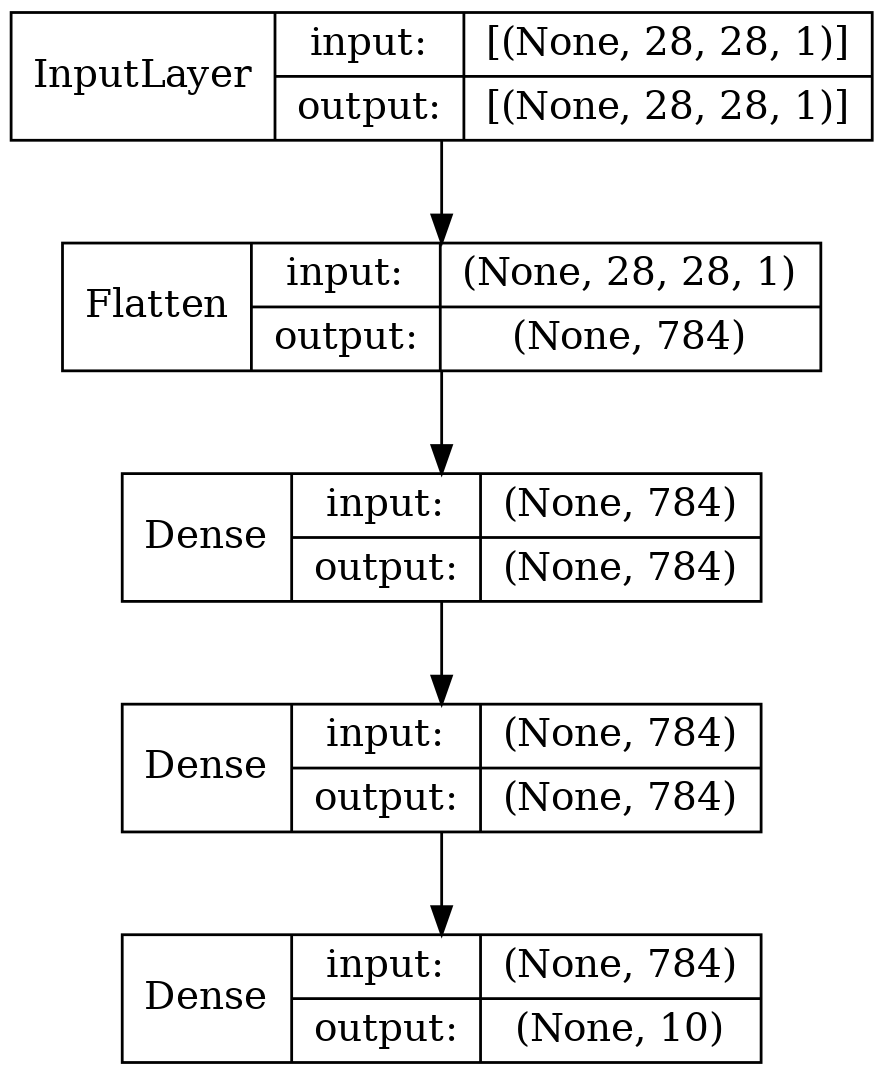

In [13]:
tf.keras.utils.plot_model(cnn_model, to_file='./report/figures/cnn_model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=200)

tf.keras.utils.plot_model(fc_model, to_file='./report/figures/fc_model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=200)

tf.keras.utils.plot_model(fc_model_noKD, to_file='./report/figures/fc_model_noKD.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=200)

In [14]:
from keras_flops import get_flops
"""
 Note : keras_flops gives error with tensorflow 2.13+
 fix is  https://github.com/tokusumi/keras-flops/issues/17#issuecomment-1692615182
"""

cnn_flops = get_flops(cnn_model)
fc_flops = get_flops(fc_model)
fc_no_distillation_flops = get_flops(fc_model_noKD)


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2023-10-30 22:04:55.258062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:04:55.258260: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-10-30 22:04:55.258376: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-30 22:04:55.258637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:04:55.258833: I tensorflow/compiler/xla/stream_executor/


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

In [15]:
print("CNN Model FLOPS:             " + str(cnn_flops))
print("FC Model FLOPS:              " + str(fc_flops))
print("FC Model without KD FLOPS:   " + str(fc_no_distillation_flops))

CNN Model FLOPS:             32792714
FC Model FLOPS:              2475882
FC Model without KD FLOPS:   2475882


# Implementing the state-of-the-art KD algorithm

In [26]:
tf.keras.backend.clear_session()


# your code start from here for step 12
"""
@article{mirzadeh2019improved,
  title={Improved Knowledge Distillation via Teacher Assistant: Bridging the Gap Between Student and Teacher},
  author={Mirzadeh, Seyed-Iman and Farajtabar, Mehrdad and Li, Ang and Ghasemzadeh, Hassan},
  journal={arXiv preprint arXiv:1902.03393},
  year={2019}
}
"""
cnn_ta_model = tf.keras.Sequential()
cnn_ta_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(28, 28, 1)))
cnn_ta_model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding="same"))
cnn_ta_model.add(tf.keras.layers.Flatten())
cnn_ta_model.add(tf.keras.layers.Dropout(0.5))
cnn_ta_model.add(tf.keras.layers.Dense(784, activation='relu'))
cnn_ta_model.add(tf.keras.layers.Dense(NUM_CLASSES))


def compute_ta_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  ta_subclass_logits = cnn_ta_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, ta_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.categorical_crossentropy(labels, ta_subclass_logits, from_logits=True)

  return ALPHA * cross_entropy_loss_value + (1 - ALPHA) * distillation_loss_value


def compute_student_loss_with_ta(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  ta_subclass_logits = cnn_ta_model(images, training=False)
  distillation_loss_value = distillation_loss(ta_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.categorical_crossentropy(labels, student_subclass_logits, from_logits=True)

  return ALPHA * cross_entropy_loss_value + (1 - ALPHA) * distillation_loss_value


Class_Accuracy:	96.74%	97.78%	98.13%	98.37%	98.47%	98.50%	98.63%	98.62%	98.71%	98.70%	98.65%	98.69%	
Class_Accuracy:	97.13%	97.95%	98.39%	98.55%	98.63%	98.72%	98.83%	98.79%	98.81%	98.91%	98.96%	98.97%	
Class_Accuracy:	96.93%	97.92%	98.21%	98.44%	98.48%	98.54%	98.61%	98.62%	98.57%	98.69%	98.62%	98.63%	


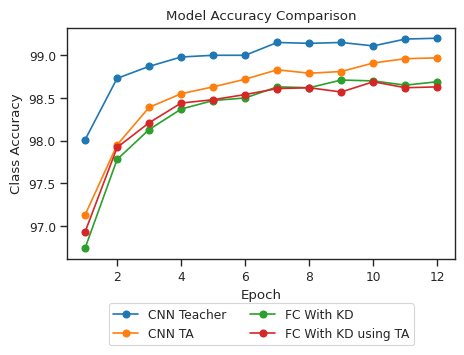

In [27]:
ALPHA = 0.5                     #   task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4    #   temperature hyperparameter

# clear model
tf.keras.backend.clear_session()
fc_model.set_weights(default_weights)
fc_model_acc = train_and_evaluate(fc_model, compute_student_loss)

cnn_ta_model_acc = train_and_evaluate(cnn_ta_model, compute_ta_loss)

# clear model
tf.keras.backend.clear_session()
fc_model.set_weights(default_weights)
fc_model_ta_acc = train_and_evaluate(fc_model, compute_student_loss_with_ta)

fig = plt.figure(figsize=(5, 3))
plt.plot(range(1, NUM_EPOCHS + 1), cnn_model_acc, "-o", label='CNN Teacher')
plt.plot(range(1, NUM_EPOCHS + 1), cnn_ta_model_acc, "-o", label='CNN TA')
plt.plot(range(1, NUM_EPOCHS + 1), fc_model_acc, "-o", label='FC With KD')
plt.plot(range(1, NUM_EPOCHS + 1), fc_model_ta_acc, "-o", label='FC With KD using TA')

plt.xlabel('Epoch')
plt.ylabel('Class Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.40))
plt.savefig('./report/figures/model_acc_comparison.png', dpi=300, bbox_inches='tight')

In [19]:
cnn_ta_flops = get_flops(cnn_ta_model)
cnn_flops = get_flops(cnn_model)
fc_flops = get_flops(fc_model)

2023-10-30 22:08:06.038906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:08:06.039090: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-10-30 22:08:06.039147: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-30 22:08:06.039320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:08:06.039508: I tensorflow/compiler/xla/stream_executor/


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

2023-10-30 22:08:06.512161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:08:06.512344: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-10-30 22:08:06.512400: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-30 22:08:06.512578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:08:06.512800: I tensorflow/compiler/xla/stream_executor/

-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profile:
node name | # float_ops
_TFProfRoot (--/2.48m flops)
  sequ

In [20]:

print("CNN Model FLOPS:     " + str(cnn_flops))
print("CNN TA Model FLOPS:  " + str(cnn_ta_flops))
print("FC Model FLOPS:      " + str(fc_flops))

CNN Model FLOPS:     32792714
CNN TA Model FLOPS:  10352730
FC Model FLOPS:      2475882


# XAI method to explain models

In [21]:
# your code start from here for step 13

import shap

test_images = []
for i in range(256):
  test_images.append(list(mnist_test.take(1))[0][0][i])
test_images = np.array(test_images)

test_labels = []
for i in range(256):
  test_labels.append(list(mnist_test.take(1))[0][1][i])
test_labels = np.array(test_labels)


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


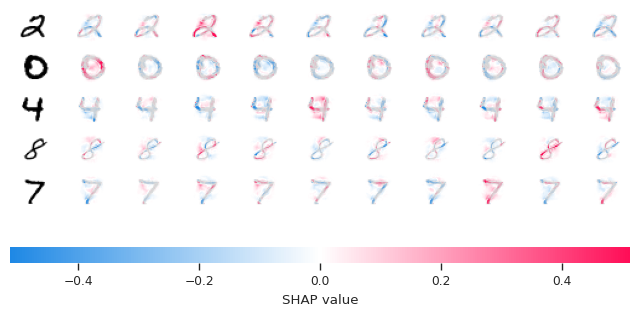

In [22]:
# CNN Model
background = test_images
e = shap.DeepExplainer(cnn_model, background)
shap_values = e.shap_values(test_images[0:5])
shap.image_plot(shap_values, -test_images[0:5], show=False, width=8)
plt.savefig('./report/figures/cnn_model_shap.png', dpi=300, bbox_inches='tight')

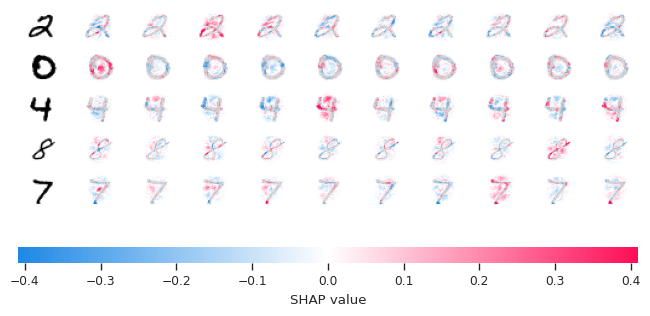

In [23]:
# FC Model
background = test_images
e = shap.DeepExplainer(fc_model, background)
shap_values = e.shap_values(test_images[0:5])
shap.image_plot(shap_values, -test_images[0:5], show=False, width=8)
plt.savefig('./report/figures/fc_model_shap.png', dpi=300, bbox_inches='tight')


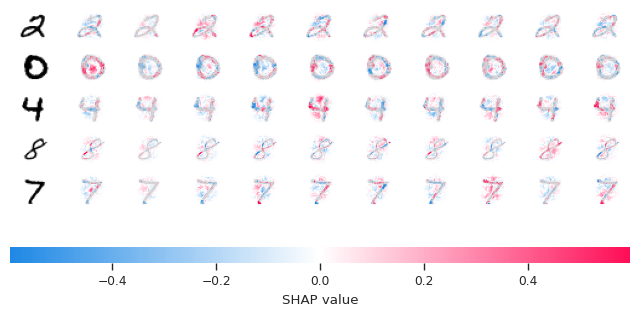

In [24]:
# FC Model without KD
background = test_images
e = shap.DeepExplainer(fc_model_noKD, background)
shap_values = e.shap_values(test_images[0:5])
shap.image_plot(shap_values, -test_images[0:5], show=False, width=8)
plt.savefig('./report/figures/fc_model_noKD_shap.png', dpi=300, bbox_inches='tight')


In [31]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout (Dropout)           (None, 12544)             0

In [32]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1238730 (4.73 MB)
Trainable params: 1238730 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
